In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.optim import Adam
import umap

# Load data
- Input: neural data binned, vocal data, labels
- Output: 1. best vocal modal 2. best contrastive model (obtained at different stages)

## 1. Choose your data between
- Warped data
- Trimmed or Padded daata
- Segmented data

### 1.1 Warped

In [2]:
all_labels = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "all_labels.pt"), weights_only=True)
data_warped_speech = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "data_warped_speech.pt"), weights_only=True)
data_warped_neural = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "data_warped_neural.pt"), weights_only=True)

In [3]:
print("Speech data shape:", data_warped_speech.shape)
print("Neural data shape:", data_warped_neural.shape)

Speech data shape: torch.Size([3459, 128, 56])
Neural data shape: torch.Size([3459, 75, 27])


### 1.2 Trimmed or Padded
note: originally the code is used for padding, so the code decides the 'max_length'
then it was expanded to trimmed, so the code still uses 'max_length' but it is actually the minimum length

In [136]:
all_data = True
no_warping = True
folder_name = "AOI_100hz_50ms_pre_end_bin" # stacked to 27

In [144]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "data")
label_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "labels")

# get files sort numerically based on filename
data_files = []
for f in os.listdir(data_dir):
    if f.endswith('.npy'):
        num = int(f.split('.')[0])  # extract number from filename like '0000.npy'
        data_files.append((num, f))

data_files.sort()  # sort based on the number
data_files = [f[1] for f in data_files]  # get filenames

# print lengths of first 10 files
print("Lengths of first 10 files:")
for i, file in enumerate(data_files[:10]):
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    print(f"File {i}: {data.shape[1]}")

data_list = []
label_list = []

#  find minimum length
min_length = float('inf')
for file in data_files:
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    min_length = min(min_length, data.shape[1])

max_length = min_length # i know its called max_length, but just for the parameters

# Second pass to load and cut data
for file in tqdm(data_files, desc="Loading data and labels"):
    # read in data
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    # Cut to minimum length
    data = data[:, :min_length]
    
    # read in label
    label_path = os.path.join(label_dir, file)
    label = np.load(label_path)

    data_list.append(data)
    label_list.append(label)

assert all(data.shape[0] == 75 for data in data_list), "All data should have 75 neurons"
assert all(data.shape[1] == min_length for data in data_list), "All data should have same length"

# Convert to tensors
padded_data = [torch.tensor(data, dtype=torch.float32) for data in data_list]
labels = [torch.tensor(label, dtype=torch.long).unsqueeze(0) for label in label_list]

# Stack
stacked_data = torch.stack(padded_data, dim=0)
stacked_labels = torch.cat(labels, dim=0)

print(f"Shape of stacked data: {stacked_data.shape}")
print(f"Shape of stacked labels: {stacked_labels.shape}")

Lengths of first 10 files:
File 0: 9
File 1: 9
File 2: 9
File 3: 9
File 4: 19
File 5: 11
File 6: 17
File 7: 8
File 8: 24
File 9: 20


Loading data and labels: 100%|██████████| 3459/3459 [00:00<00:00, 3713.07it/s]

Shape of stacked data: torch.Size([3459, 75, 6])
Shape of stacked labels: torch.Size([3459])


In [143]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", "dtw", "spectrogram")

data_files = []
for f in os.listdir(data_dir):
    if f.endswith('.npy'):
        num = int(f.split('_')[1])  # Extract the number after 'spec_'
        data_files.append((num, f))

data_files.sort()  # This will sort based on the number
data_files = [f[1] for f in data_files]  # Keep just the filenames

# Print lengths of first 10 files
print("Lengths of first 10 files:")
for i, file in enumerate(data_files[:10]):
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    print(f"File {i}: {data.shape[1]}")

# First pass to get length distribution
lengths = []
for file in data_files:
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    lengths.append(data.shape[1])

min_length = min(lengths)
max_length = max(lengths)
mean_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"\nLength distribution:")
print(f"Min length: {min_length}")
print(f"Max length: {max_length}")
print(f"Mean length: {mean_length:.2f}")
print(f"Std length: {std_length:.2f}")

sorted_data = []
labels = []

# Load data and labels in order
for file in tqdm(data_files, desc="Loading data and labels"):
    label = int(file.split('_')[3])  # Get label from filename
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    sorted_data.append(data)
    labels.append(label)

Lengths of first 10 files:
File 0: 12
File 1: 12
File 2: 11
File 3: 12
File 4: 37
File 5: 17
File 6: 30
File 7: 10
File 8: 49
File 9: 37

Length distribution:
Min length: 3
Max length: 56
Mean length: 27.63
Std length: 14.38


Loading data and labels: 100%|██████████| 3459/3459 [00:00<00:00, 7058.83it/s]


### 1.3 segments

In [2]:
# Define paths to data directories
# base_path = "M:/neuro2voc/task-5/AOI_250Hz_segment_step_size_1" # 40ms segments 1
# base_path = "M:/neuro2voc/task-5/AOI_250Hz_CEBRA" #4ms segments
# base_path = "M:/neuro2voc/task-5/AOI_250Hz_Window_40ms_Pre_20ms_Post_20ms" # 40 ms segments 2
base_path = "M:/neuro2voc/task-5/AOI_250Hz_Window_80ms_Pre_20ms_Post_20ms" # 80 ms segments

neural_dir = os.path.join(base_path, "neural")
speech_dir = os.path.join(base_path, "speech")
label_dir = os.path.join(base_path, "label")

# get files and sort numerically based on filename
data_files = []
for f in os.listdir(neural_dir):
    if f.endswith('.pt'):
        num = int(f.split('.')[0])  # Extract e
        data_files.append((num, f))

data_files.sort()  # Sort 
data_files = [f[1] for f in data_files]  # get just the filenames

neural_list = []
speech_list = []
label_list = []
for file in tqdm(data_files, desc="Loading data"):
    neural_path = os.path.join(neural_dir, file)
    speech_path = os.path.join(speech_dir, file)
    label_path = os.path.join(label_dir, file)
    
    neural = torch.load(neural_path, weights_only=True).float()
    speech = torch.load(speech_path, weights_only=True).float()
    label = torch.load(label_path, weights_only=True).float()
    
    neural_list.append(neural)
    speech_list.append(speech)
    label_list.append(label)

# Stack
stacked_neural = torch.stack(neural_list, dim=0)
stacked_speech = torch.stack(speech_list, dim=0)
stacked_labels = torch.stack(label_list, dim=0)

print(f"Shape of stacked neural data: {stacked_neural.shape}")
print(f"Shape of stacked speech data: {stacked_speech.shape}")
print(f"Shape of stacked labels: {stacked_labels.shape}")

Loading data: 100%|██████████| 63806/63806 [15:38<00:00, 67.95it/s]


Shape of stacked neural data: torch.Size([63806, 75, 20])
Shape of stacked speech data: torch.Size([63806, 128, 20])
Shape of stacked labels: torch.Size([63806])


In [3]:
neural_seq_length = stacked_neural.shape[-1]
speech_seq_length = stacked_speech.shape[-1]
print(f"Neural sequence length: {neural_seq_length}")
print(f"Speech sequence length: {speech_seq_length}")

assert neural_seq_length == speech_seq_length # both in 250Hz so same length
name = f"{4*neural_seq_length}ms"

Neural sequence length: 20
Speech sequence length: 20


# 2 Model

In [6]:
class CombinedVAE(nn.Module):
    def __init__(self, 
                 neural_input_channels=75, neural_input_length=10,
                 speech_input_channels=1, speech_height=128, speech_width=10,
                 hidden_dim=256, latent_dim=32):
        super(CombinedVAE, self).__init__()

        self.latent_dim = latent_dim

        self.neural_encoder = nn.Sequential(
            nn.Conv1d(neural_input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * neural_input_length, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.speech_encoder_conv = nn.Sequential(
            nn.BatchNorm2d(speech_input_channels),
            nn.Conv2d(speech_input_channels, 16, 3, 1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        with torch.no_grad():
            sample_input = torch.zeros(1, speech_input_channels, speech_height, speech_width)
            conv_output = self.speech_encoder_conv(sample_input)
            self.decoder_spatial_dims = conv_output.shape[2:]
            flatten_size = conv_output.view(-1).size(0)

        self.speech_encoder_fc = nn.Sequential(
            nn.Linear(flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  
        )


        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, flatten_size),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, speech_input_channels, 3, 2, padding=1, output_padding=1),
        )

        self.final_adjust = nn.AdaptiveAvgPool2d((speech_height, speech_width))

    def encode(self, neural_x, speech_x):
        neural_z = self.neural_encoder(neural_x) if neural_x is not None else None

        if speech_x is not None:
            h = self.speech_encoder_conv(speech_x)
            h = h.view(h.size(0), -1)
            h = self.speech_encoder_fc(h)
            mu, logvar = torch.chunk(h, 2, dim=1)
        else:
            device = neural_x.device if neural_x is not None else 'cpu'
            batch_size = neural_x.size(0) if neural_x is not None else speech_x.size(0)
            mu = torch.zeros(batch_size, self.latent_dim).to(device)
            logvar = torch.zeros(batch_size, self.latent_dim).to(device)

        return neural_z, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 64, *self.decoder_spatial_dims) # if self.decoder_spatial_dims is (128, 10) this is equal to h.view(h.size(0), 64, 128, 10)
        h = self.decoder_conv(h)
        h = self.final_adjust(h)
        return h

    def forward(self, neural_x=None, speech_x=None, mode='pretrain'):
        if mode == 'pretrain':
            # Hey! We're just working with speech data in pretraining mode
            _, mu, logvar = self.encode(None, speech_x)
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
            return recon_x, mu, logvar
        else:
            # Here's our regular forward pass with all the bells and whistles!
            neural_z, mu, logvar = self.encode(neural_x, speech_x)
            if speech_x is not None:
                speech_z = mu
            else:
                speech_z = None
            if neural_z is not None:
                z = neural_z
            else:
                z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
            return recon_x, neural_z, speech_z, mu, logvar

    def pretrain_loss_function(self, recon_x, speech_x, mu, logvar, beta=0.1):
        recon_loss = F.mse_loss(recon_x, speech_x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + beta * kld_loss
        return total_loss, recon_loss, kld_loss

    def loss_function(self, recon_x, speech_x, neural_z, speech_z, mu, logvar, alpha=1.0, beta=0.1, gamma=1.0):
        recon_loss = F.mse_loss(recon_x, speech_x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Let's add some contrastive loss if we have both neural and speech data
        if neural_z is not None and speech_z is not None:
            contrastive_loss = self.contrastive_loss(neural_z, speech_z)
        else:
            contrastive_loss = torch.tensor(0.0).to(speech_x.device)

        total_loss = alpha * recon_loss + beta * kld_loss + gamma * contrastive_loss
        return total_loss, recon_loss, kld_loss, contrastive_loss

    def contrastive_loss(self, neural_z, speech_z, temperature=0.07):
        neural_z_normalized = F.normalize(neural_z, dim=1)
        speech_z_normalized = F.normalize(speech_z, dim=1)
        
        similarity_matrix = torch.matmul(neural_z_normalized, speech_z_normalized.T) / temperature
        
        batch_size = neural_z.size(0)
        labels = torch.arange(batch_size).long().to(neural_z.device)
        
        loss_i = F.cross_entropy(similarity_matrix, labels)
        loss_t = F.cross_entropy(similarity_matrix.T, labels)
        
        loss = (loss_i + loss_t) / 2
        return loss

# 3 Train

In [7]:
class PretrainDataset(Dataset):
    def __init__(self, speech_data):
        """
        speech_data: tensor of shape [batch_size, speech_input_channels, speech_height, speech_width]
        """
        self.speech_data = speech_data
        
        # Reshape speech data to [batch_size, 1, height, width] for 2D convolutions
        if len(speech_data.shape) == 3:
            self.speech_data = speech_data.unsqueeze(1)
            
    def __len__(self):
        return len(self.speech_data)
    
    def __getitem__(self, idx):
        return self.speech_data[idx]

class ContrastiveDataset(Dataset):
    def __init__(self, neural_data, speech_data):
        """
        neural_data: tensor of shape [batch_size, neural_input_channels, neural_seq_len]
        speech_data: tensor of shape [batch_size, speech_input_channels, speech_height, speech_width]
        """
        self.neural_data = neural_data
        self.speech_data = speech_data
        
        # Reshape speech data to [batch_size, 1, height, width] for 2D convolutions
        if len(speech_data.shape) == 3:
            self.speech_data = speech_data.unsqueeze(1)
            
    def __len__(self):
        return len(self.neural_data)
    
    def __getitem__(self, idx):
        return self.neural_data[idx], self.speech_data[idx]

# pretrain dataset
pretrain_dataset = PretrainDataset(stacked_speech)
contrastive_dataset = ContrastiveDataset(stacked_neural, stacked_speech)

In [8]:
batch_size = 512

# Split  
pretrain_train_size = int(0.8 * len(pretrain_dataset))
pretrain_val_size = len(pretrain_dataset) - pretrain_train_size

pretrain_train_dataset, pretrain_val_dataset = random_split(
    pretrain_dataset, 
    [pretrain_train_size, pretrain_val_size]
)

pretrain_train_loader = DataLoader(
    pretrain_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

pretrain_val_loader = DataLoader(
    pretrain_val_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

contrastive_train_size = int(0.8 * len(contrastive_dataset))
contrastive_val_size = len(contrastive_dataset) - contrastive_train_size

contrastive_train_dataset, contrastive_val_dataset = random_split(
    contrastive_dataset,
    [contrastive_train_size, contrastive_val_size]
)

contrastive_train_loader = DataLoader(
    contrastive_train_dataset,
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0
)

contrastive_val_loader = DataLoader(
    contrastive_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [9]:
print("Pretrain dataset size:", len(pretrain_dataset))
print("Contrastive dataset size:", len(contrastive_dataset))
print("Batch size:", batch_size)
print("Number of pretrain batches:", len(pretrain_train_loader))
print("Number of contrastive batches:", len(contrastive_train_loader))

Pretrain dataset size: 63806
Contrastive dataset size: 63806
Batch size: 512
Number of pretrain batches: 100
Number of contrastive batches: 100


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = CombinedVAE(
    neural_input_channels=75, 
    neural_input_length=neural_seq_length,
    speech_input_channels=1, 
    speech_height=128, 
    speech_width=speech_seq_length,
    hidden_dim=256, 
    latent_dim=32
).to(device)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [13]:
num_epochs = 50000
best_val_loss = float('inf')

In [14]:
assert name is not None

In [14]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, speech_x in enumerate(pretrain_train_loader):
        speech_x = speech_x.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_x, mu, logvar = model(speech_x=speech_x, mode='pretrain')
        
        # Calculate loss
        loss, recon_loss, kld_loss = model.pretrain_loss_function(
            recon_x, speech_x, mu, logvar, beta=0.1
        )
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(pretrain_train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for speech_x in pretrain_val_loader:
            speech_x = speech_x.to(device)
            recon_x, mu, logvar = model(speech_x=speech_x, mode='pretrain')
            loss, _, _ = model.pretrain_loss_function(recon_x, speech_x, mu, logvar, beta=0.1)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(pretrain_val_loader)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'best_pretrained_vocal_model_{name}.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f}')

Epoch [1/50000] Train Loss: 4551.8609 Val Loss: 4500.2296
Epoch [2/50000] Train Loss: 4457.2959 Val Loss: 4400.8321
Epoch [3/50000] Train Loss: 4354.1626 Val Loss: 4289.4447
Epoch [4/50000] Train Loss: 4238.0269 Val Loss: 4170.2967
Epoch [5/50000] Train Loss: 4110.2437 Val Loss: 4041.3565
Epoch [6/50000] Train Loss: 3968.3688 Val Loss: 3886.3446
Epoch [7/50000] Train Loss: 3814.1353 Val Loss: 3730.8674
Epoch [8/50000] Train Loss: 3642.4669 Val Loss: 3557.2543
Epoch [9/50000] Train Loss: 3465.6884 Val Loss: 3379.3225
Epoch [10/50000] Train Loss: 3288.2149 Val Loss: 3217.8730
Epoch [11/50000] Train Loss: 3108.8826 Val Loss: 3021.1175
Epoch [12/50000] Train Loss: 2929.2845 Val Loss: 2845.2997
Epoch [13/50000] Train Loss: 2748.8167 Val Loss: 2645.0846
Epoch [14/50000] Train Loss: 2560.0846 Val Loss: 2485.1895
Epoch [15/50000] Train Loss: 2371.1589 Val Loss: 2268.1726
Epoch [16/50000] Train Loss: 2194.3048 Val Loss: 2106.7348
Epoch [17/50000] Train Loss: 2025.8062 Val Loss: 1947.2069
Epoch 

KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load(f'best_pretrained_vocal_model_{name}.pth'))
print(f'You loaded best_pretrained_vocal_model_{name}.pth')

You loaded best_pretrained_vocal_model_80ms.pth


C:\Users\askrb\AppData\Local\Temp\ipykernel_82616\3587301987.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_pretrained_vocal_mod

# 4 Visualize trained vocal model

In [16]:
device = next(model.parameters()).device
# warped_data or data etc.
stacked_data = stacked_speech.to(device)#.float() 
stacked_data.shape

torch.Size([63806, 128, 20])

Reconstructed data shape: torch.Size([5, 1, 128, 1])


C:\Users\askrb\AppData\Local\Temp\ipykernel_79652\3160178815.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


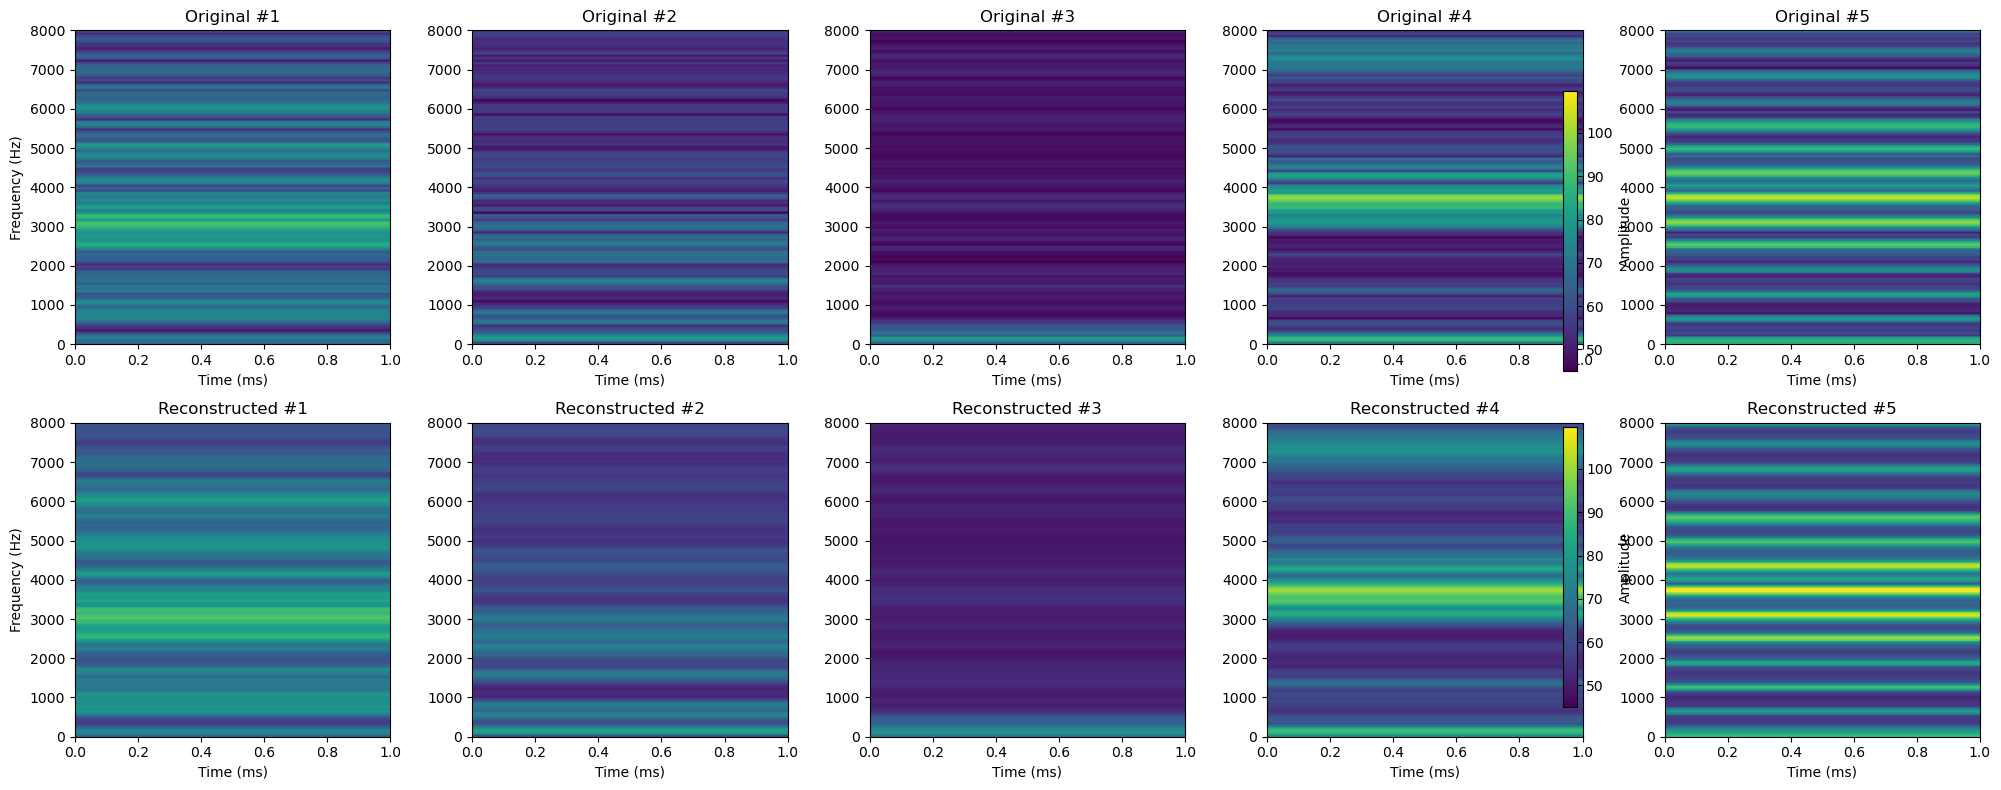

In [14]:
# random indices
num_samples = 5
random_indices = torch.randint(0, len(stacked_data), (num_samples,))
selected_data = stacked_data[random_indices]
selected_data = selected_data.unsqueeze(1)  # Add channel dimension to make it 4D

with torch.no_grad():
    recon_data, mu, logvar = model(speech_x=selected_data, mode='pretrain')
    
    print("Reconstructed data shape:", recon_data.shape)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    # global min/max
    vmin = min(selected_data.cpu().numpy().min(), recon_data.cpu().numpy().min())
    vmax = max(selected_data.cpu().numpy().max(), recon_data.cpu().numpy().max())
    
    for i in range(num_samples):
        # Original
        im1 = axes[0,i].imshow(selected_data[i, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                       origin='lower', extent=[0, selected_data.shape[-1], 0, 8000],
                       vmin=vmin, vmax=vmax)
        if i == 0:
            axes[0,i].set_ylabel('Frequency (Hz)')
        axes[0,i].set_title(f'Original #{i+1}')
        axes[0,i].set_xlabel('Time (ms)')
        
        # Reconstructed  
        im2 = axes[1,i].imshow(recon_data[i, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                       origin='lower', extent=[0, recon_data.shape[-1], 0, 8000],
                       vmin=vmin, vmax=vmax)
        if i == 0:
            axes[1,i].set_ylabel('Frequency (Hz)')
        axes[1,i].set_title(f'Reconstructed #{i+1}')
        axes[1,i].set_xlabel('Time (ms)')
    
    plt.colorbar(im1, ax=axes[0,:].ravel().tolist(), label='Amplitude')
    plt.colorbar(im2, ax=axes[1,:].ravel().tolist(), label='Amplitude')
    
    plt.tight_layout()
    plt.show()

# 5 Contrastive learning

In [17]:
# freeze
for param in model.speech_encoder_conv.parameters():
    param.requires_grad = False
for param in model.speech_encoder_fc.parameters():
    param.requires_grad = False
for param in model.decoder_fc.parameters():
    param.requires_grad = False
for param in model.decoder_conv.parameters():
    param.requires_grad = False
for param in model.final_adjust.parameters():
    param.requires_grad = False

In [18]:
# only optimize the neural decoder
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)

In [19]:
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_pos_sim = 0
    epoch_neg_sim = 0
    num_batches = len(contrastive_train_loader)
    
    for batch_idx, (neural_x, speech_x) in enumerate(contrastive_train_loader):
        neural_x, speech_x = neural_x.to(device), speech_x.to(device)
        optimizer.zero_grad()
        
        # Forward pass (contrastive learning mode)
        recon_x, neural_z, speech_z, mu, logvar = model(
            neural_x=neural_x,
            speech_x=speech_x, 
            mode='contrastive'
        )
        
        # Calculate loss
        loss, _, _, contrastive_loss = model.loss_function(
            recon_x, speech_x, neural_z, speech_z, mu, logvar,
            alpha=0.0,  # no reconstruction loss
            beta=0.0,   # no KL loss
            gamma=1.0   # Only contrastive loss
        )
        
        # calculate similarities
        pos_sim = torch.nn.functional.cosine_similarity(neural_z, speech_z).mean()
        neg_sim = torch.nn.functional.cosine_similarity(
            neural_z.unsqueeze(1), 
            speech_z.roll(1, dims=0).unsqueeze(0)
        ).mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_pos_sim += pos_sim.item()
        epoch_neg_sim += neg_sim.item()

    
    # Calculate and print epoch averages
    avg_loss = epoch_loss / num_batches
    avg_pos_sim = epoch_pos_sim / num_batches
    avg_neg_sim = epoch_neg_sim / num_batches
    
    print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Pos_sim={avg_pos_sim:.4f}, Neg_sim={avg_neg_sim:.4f}')

Epoch 1: Loss=6.1162, Pos_sim=-0.3500, Neg_sim=-0.1889
Epoch 2: Loss=6.1099, Pos_sim=-0.3484, Neg_sim=-0.1889
Epoch 3: Loss=6.1084, Pos_sim=-0.3479, Neg_sim=-0.1884
Epoch 4: Loss=6.1052, Pos_sim=-0.3464, Neg_sim=-0.1878
Epoch 5: Loss=6.1065, Pos_sim=-0.3469, Neg_sim=-0.1883
Epoch 6: Loss=6.1030, Pos_sim=-0.3464, Neg_sim=-0.1878
Epoch 7: Loss=6.1027, Pos_sim=-0.3458, Neg_sim=-0.1874
Epoch 8: Loss=6.1014, Pos_sim=-0.3452, Neg_sim=-0.1874
Epoch 9: Loss=6.1003, Pos_sim=-0.3455, Neg_sim=-0.1876
Epoch 10: Loss=6.0989, Pos_sim=-0.3448, Neg_sim=-0.1872
Epoch 11: Loss=6.0979, Pos_sim=-0.3447, Neg_sim=-0.1873
Epoch 12: Loss=6.0962, Pos_sim=-0.3443, Neg_sim=-0.1871
Epoch 13: Loss=6.0950, Pos_sim=-0.3438, Neg_sim=-0.1867
Epoch 14: Loss=6.0945, Pos_sim=-0.3437, Neg_sim=-0.1867
Epoch 15: Loss=6.0925, Pos_sim=-0.3434, Neg_sim=-0.1870
Epoch 16: Loss=6.0909, Pos_sim=-0.3427, Neg_sim=-0.1865
Epoch 17: Loss=6.0903, Pos_sim=-0.3422, Neg_sim=-0.1861
Epoch 18: Loss=6.0894, Pos_sim=-0.3423, Neg_sim=-0.1864
E

KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict(), f'best_contrastive_model_{name}.pth')
print(f'Model saved as best_contrastive_model_{name}.pth'	)

Model saved as best_contrastive_model_4ms.pth


# 6 Visualize trained contrastive model

In [18]:
model.load_state_dict(torch.load(f'best_contrastive_model_{name}.pth'))
print(f'Model loaded from best_contrastive_model_{name}.pth')

Model loaded from best_contrastive_model_80ms.pth


C:\Users\askrb\AppData\Local\Temp\ipykernel_82616\3034970837.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_contrastive_model_{n

### 6.1 UMAP

In [19]:
# all latent embeddings
with torch.no_grad():
    # neural and speech latent representations for all data
    neural_z, _, _ = model.encode(stacked_neural.to(device), None)
    
    # reshape speech data to 4D (batch, channels, height, width) for Conv2d
    speech_4d = stacked_speech.unsqueeze(1).to(device)  # add channel dimension
    _, speech_z, _ = model.encode(None, speech_4d)

    # move to CPU for visualization
    neural_z = neural_z.cpu().numpy()
    speech_z = speech_z.cpu().numpy()

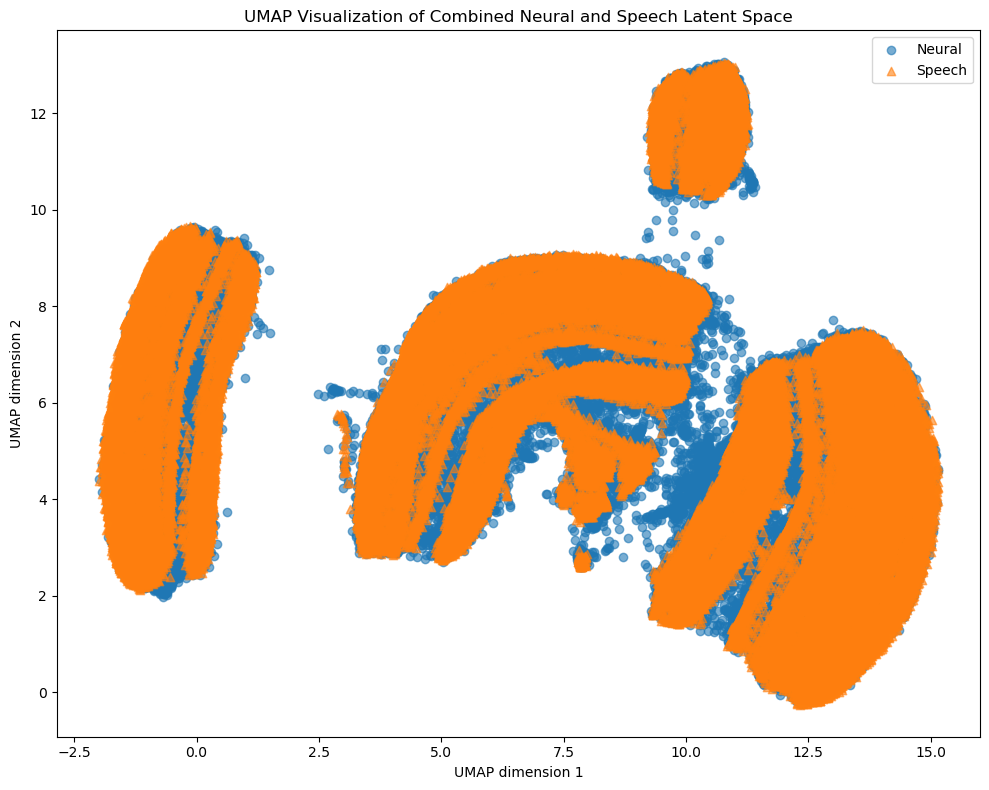

In [23]:
# Ccmbine neural and speech embeddings
combined_z = np.vstack([neural_z, speech_z])
data_labels = np.array(['Neural']*len(neural_z) + ['Speech']*len(speech_z))

# UMAP 
reducer = umap.UMAP(n_components=2)
combined_z_2d = reducer.fit_transform(combined_z)

plt.figure(figsize=(10, 8))

for label, marker in zip(['Neural', 'Speech'], ['o', '^']):
    mask = data_labels == label
    plt.scatter(combined_z_2d[mask, 0], combined_z_2d[mask, 1],
               label=label, alpha=0.6, marker=marker)

plt.title('UMAP Visualization of Combined Neural and Speech Latent Space')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.legend()
plt.tight_layout()
plt.savefig(f'UMAP_{name}_combined_joint.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
reducer = umap.UMAP(n_components=2)
neural_z_2d = reducer.fit_transform(neural_z)
speech_z_2d = reducer.fit_transform(speech_z)

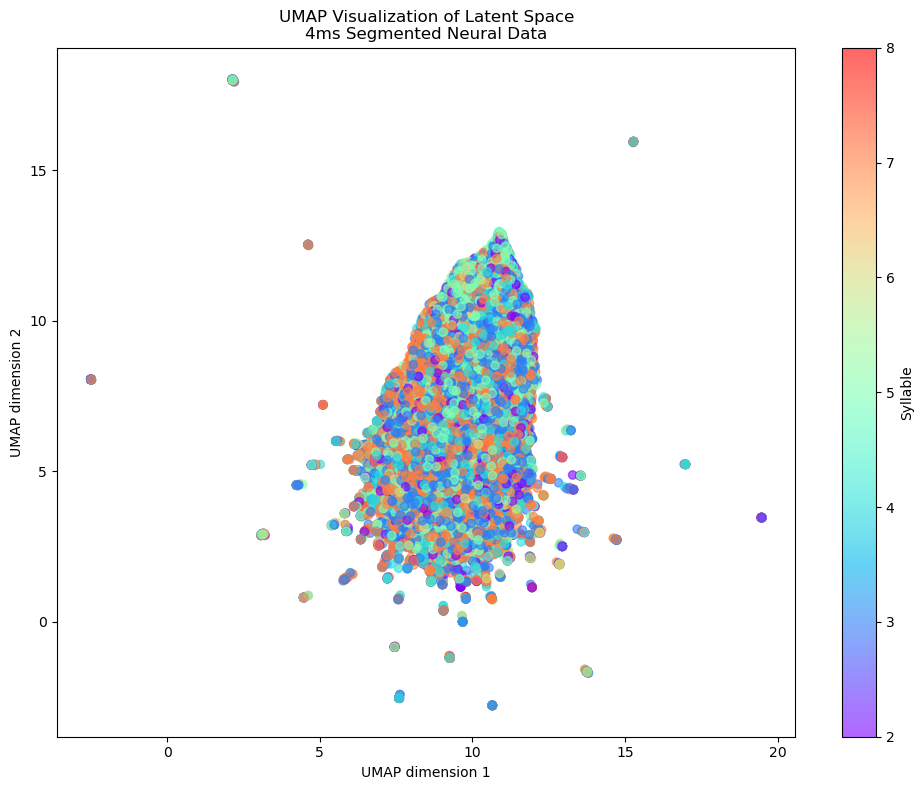

In [24]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(neural_z_2d[:, 0], neural_z_2d[:, 1], 
                     c=stacked_labels, cmap='rainbow', alpha=0.6)
plt.title(f'UMAP Visualization of Latent Space\n{name} Segmented Neural Data')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar(scatter, label='Syllable')
plt.tight_layout()
plt.savefig(f'UMAP_{name}_neural_joint.pdf', dpi=300, bbox_inches='tight')
plt.show()

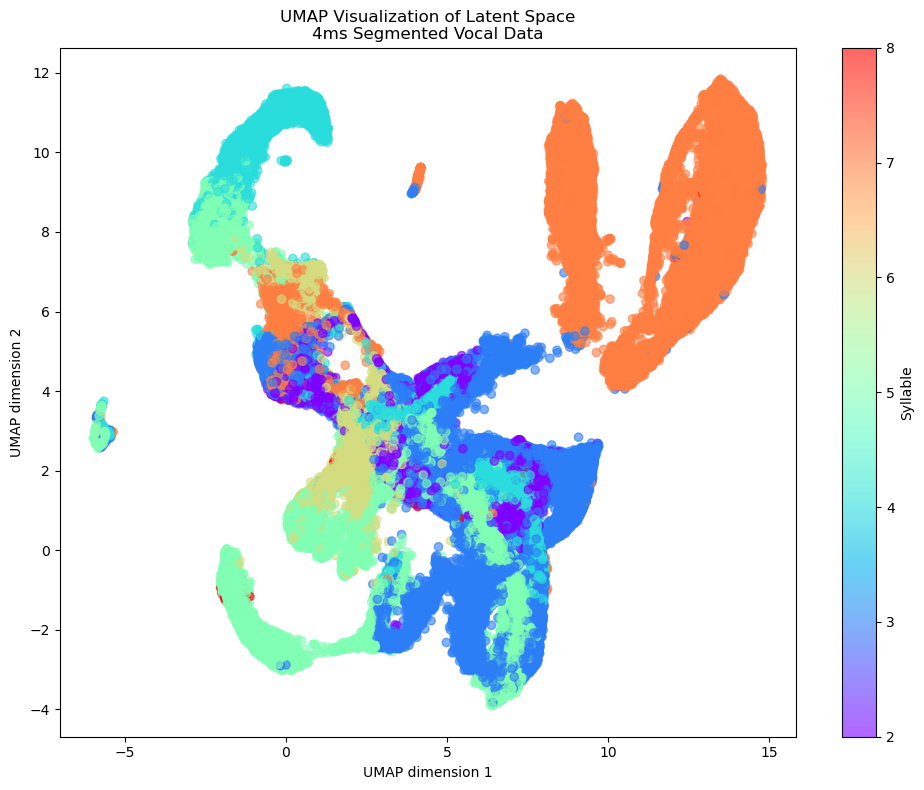

In [25]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(speech_z_2d[:, 0], speech_z_2d[:, 1], 
                     c=stacked_labels, cmap='rainbow', alpha=0.6)
plt.title(f'UMAP Visualization of Latent Space\n{name} Segmented Vocal Data')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar(scatter, label='Syllable')
plt.tight_layout()
plt.savefig(f'UMAP_{name}_voc_joint.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 6.2 Visualize generated speech

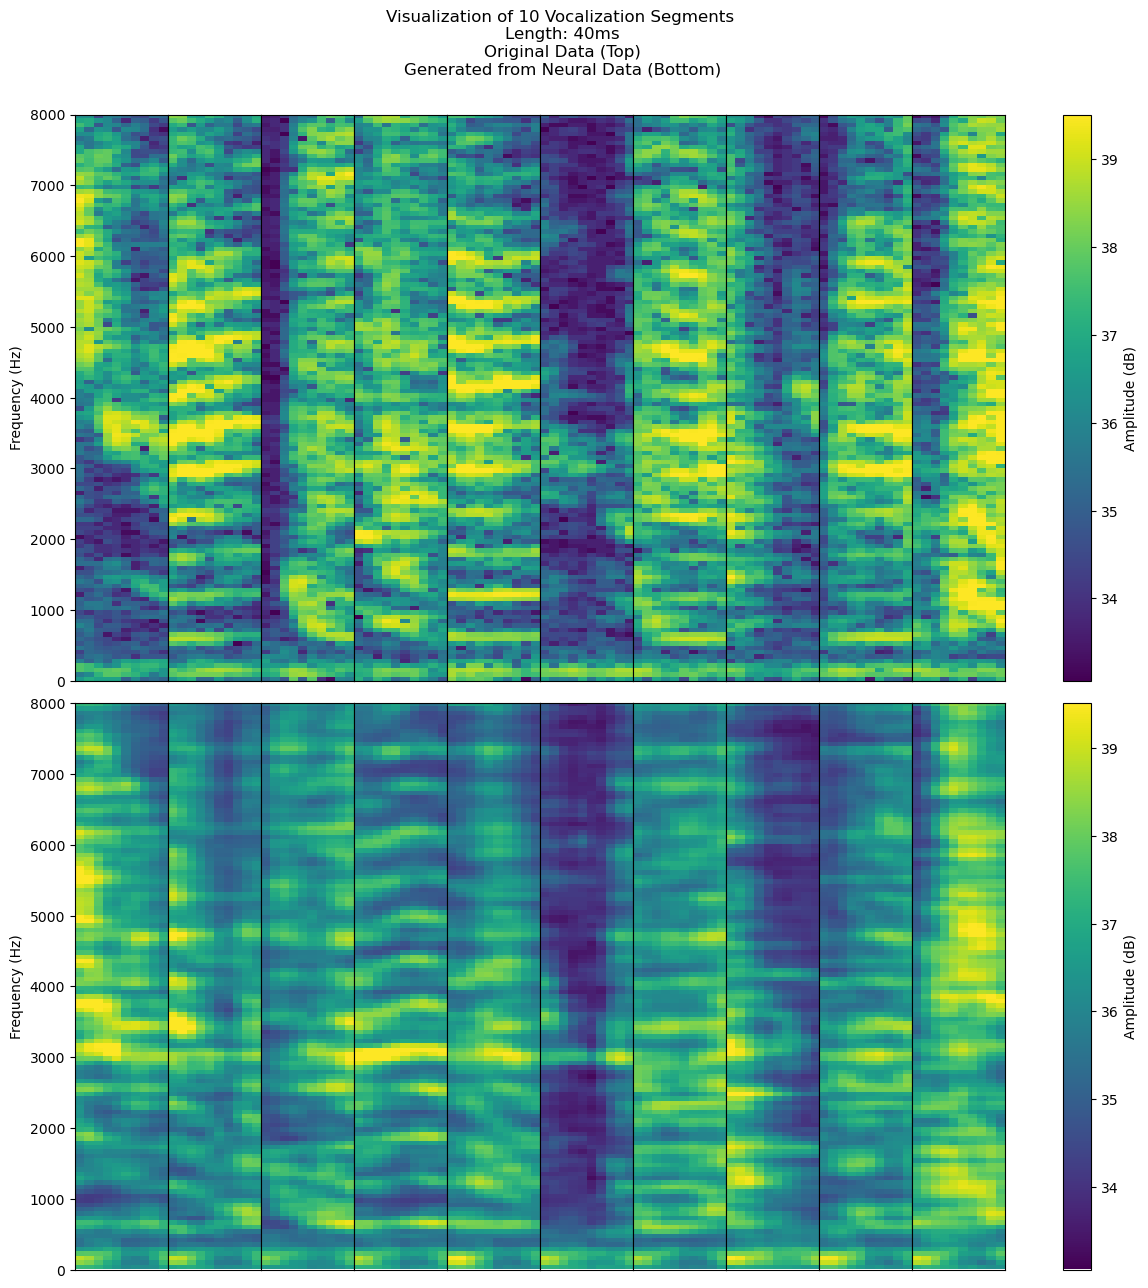

In [55]:
output_dir = "visualization_results/joint_model/"
os.makedirs(output_dir, exist_ok=True)

# random samples
num_samples = 10
indices = torch.randint(0, len(stacked_neural), (num_samples,))

selected_neural = stacked_neural[indices]
selected_speech = stacked_speech[indices]

if len(selected_neural.shape) == 3:
    selected_neural = selected_neural.reshape(num_samples, -1, selected_neural.shape[-1])

# Move to device
selected_neural = selected_neural.to(device)
selected_speech = selected_speech.to(device)

with torch.no_grad():
    # neural latent representation and generate speech
    neural_z, _, _ = model.encode(selected_neural, None)
    generated_speech = model.decode(neural_z)
    
    # Convert to dB
    generated_speech_db = 20 * torch.log10(generated_speech.squeeze() + 1e-10)
    original_speech_db = 20 * torch.log10(selected_speech.squeeze() + 1e-10)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 15), 
                            gridspec_kw={'wspace': 0, 'hspace': 0.04})
    
    vmin = min(original_speech_db.min().item(), generated_speech_db.min().item())
    vmax = max(original_speech_db.max().item(), generated_speech_db.max().item()) 

    # plot spectrograms
    for i in range(num_samples):
        # Original speech
        im1 = axes[0, i].imshow(original_speech_db[i].cpu().numpy(),
                               aspect='auto', cmap='viridis',
                               origin='lower', extent=[0, selected_speech.shape[-1], 0, 8000],
                               vmin=vmin, vmax=vmax-1)
        if i == num_samples-1:  # Only add colorbar for last plot in row
            plt.colorbar(im1, ax=axes[0, :].ravel().tolist(), label='Amplitude (dB)')
        if i == 0:  # Only show yticks for leftmost plot
            axes[0, i].set_ylabel('Frequency (Hz)')
        else:
            axes[0, i].set_yticks([])
        axes[0, i].set_xticks([])
        
        # Generated speech
        im2 = axes[1, i].imshow(generated_speech_db[i].cpu().numpy(),
                               aspect='auto', cmap='viridis', 
                               origin='lower', extent=[0, generated_speech.shape[-1], 0, 8000],
                               vmin=vmin, vmax=vmax-1)
        if i == num_samples-1: 
            plt.colorbar(im2, ax=axes[1, :].ravel().tolist(), label='Amplitude (dB)')
        if i == 0: 
            axes[1, i].set_ylabel('Frequency (Hz)')
        else:
            axes[1, i].set_yticks([])
        axes[1, i].set_xticks([])

    fig.suptitle(f'Visualization of {num_samples} Vocalization Segments \nLength: {name}\nOriginal Data (Top)\nGenerated from Neural Data (Bottom)', 
                 x=0.45, y=0.95)
    plt.savefig(output_dir + f'neural2vocal_{name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 7 Evaluation

In [22]:
latent_np = neural_z
labels_np = stacked_labels
labels_np = labels_np - 2  # now it starts from 0

X_train, X_test, y_train, y_test = train_test_split(latent_np, labels_np, test_size=0.2, random_state=42)

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred))

# RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# SGB
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

SVM Results:
Accuracy: 0.910

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       379
         1.0       0.87      0.92      0.89      3967
         2.0       0.91      0.84      0.87      1153
         3.0       0.95      0.91      0.93      2828
         4.0       1.00      0.35      0.52        34
         5.0       0.94      0.94      0.94      4388
         6.0       0.00      0.00      0.00        13

    accuracy                           0.91     12762
   macro avg       0.78      0.67      0.70     12762
weighted avg       0.91      0.91      0.91     12762



c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


Random Forest Results:
Accuracy: 0.844

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.30      0.44       379
         1.0       0.77      0.89      0.83      3967
         2.0       0.93      0.59      0.72      1153
         3.0       0.92      0.85      0.88      2828
         4.0       0.00      0.00      0.00        34
         5.0       0.86      0.92      0.89      4388
         6.0       0.00      0.00      0.00        13

    accuracy                           0.84     12762
   macro avg       0.62      0.51      0.54     12762
weighted avg       0.85      0.84      0.84     12762



c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


XGBoost Results:
Accuracy: 0.896

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70       379
         1.0       0.85      0.90      0.88      3967
         2.0       0.91      0.82      0.86      1153
         3.0       0.93      0.90      0.91      2828
         4.0       0.88      0.21      0.33        34
         5.0       0.92      0.94      0.93      4388
         6.0       0.00      0.00      0.00        13

    accuracy                           0.90     12762
   macro avg       0.75      0.63      0.66     12762
weighted avg       0.90      0.90      0.89     12762



c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()